# Observation Planning

In case you want to plan future observations, multiple clever strategies can be used. Here, I will demonstrate

1. Case of SNU Pyeongchang Campus telescope (60-cm, using limiting mag of V=14.5 for polarimeter)
    * Focusing on asteroids, not comets
    * Focusing on MBAs, not NEAs.
2. First, only ~1% of known asteroids can be "bright enough"
    * "maximum possible" brightness can be obtained by assuming r_hel=q, r_obs=MOID, and α=0.
3. For the selected 1% of objects (say ``useful`` objects), calculate their r_hel, r_obs, and alpha.
    * This does not have to be accurate. Use simple approximations in N-body.
    * Timestep for the calculations is 1 day for the next 60 days.
4. Then choose objects that can be bright enough for that time interval (60d)
    * "maximum possible" brightness can be obtained by assuming r_hel=min(r_hel), r_obs=min(r_obs), and α=min(α) during that interval.
5. Only ~10^3 objects (say ``vmag_cut`` objects) will be chosen. For them, do "accurate" calculations.
    * Use Cone FOV with 150° radius, i.e., select solar-elongation > 30° objects only.

In [3]:
from pathlib import Path

import kete
import numpy as np
import pandas as pd
from astropy import units as u
from astropy.io import fits
from astropy.time import Time
from astropy.wcs import WCS
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt

import skyloc as sloc

%config InlineBackend.figure_format = 'retina'
# %matplotlib notebook
InteractiveShell.ast_node_interactivity = 'last_expr'

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

observatory = (37.53660, 128.444790, 0.3)  # lat, lon in deg, height in km
VMAG_CUT = 14.5

In [4]:
# Download the orbit information file from JPL SBDB
# ~ 4-10min for the first time, ~10s for subsequent runs.
orb, m_ng = sloc.fetch_orb(
    output="orb_sbdb.parq",
    update_output=999,  # days - if output's last-modified is older than this, it will be updated
    # filters=[
        # ("kind", "not in", ("au")),
        # ("kind", "in", ("cu", "cn")),
        # ("condition_code", "in", ["0", "1"]),
    # ]
)
print("Number of objects, number of columns: ", orb.shape)
print("latest 'soln_date' [US/Pacific]     : ", orb["soln_date"].max())

# Just for printing purposes...
n_ng = np.sum(m_ng)

print("Number of     grav objects          : ", orb.shape[0] - n_ng)
print("Number of non-grav objects          : ", n_ng)

Number of objects, number of columns:  (1449241, 36)
latest 'soln_date' [US/Pacific]     :  2025-06-09 07:42:01
Number of     grav objects          :  1448434
Number of non-grav objects          :  807


In [5]:
if "moid" not in orb.columns:
    sq = sloc.SBDBQuery(fields=["pdes", "moid"])
    df = sq.query()
    # fill moid column based on orb["desig"] and df["pdes"]
    orb = orb.merge(df[["pdes", "moid"]], left_on="desig", right_on="pdes", how="left")

# Assume phase=0, r_hel=q, r_obs=moid, H=H to get theoretical V-mag:
vmag = sloc.iau_hg_mag(hmag=orb["H"], rhel=orb["peri_dist"], robs=orb["moid"], alpha__deg=0)
vmask = (vmag < VMAG_CUT) & ~pd.isna(vmag)
orb_useful = orb.loc[vmask].copy().reset_index(drop=True)
print(len(orb_useful), f"objects with V-mag < {VMAG_CUT}")

14138 objects with V-mag < 14.5


In [6]:
# === 1. Crude calculation
times = Time("2025-12-01") + np.arange(0, 60, 1) * u.day
fovs_c = []
for _t in times:
    jd_tdb = _t.tdb.jd
    name = _t.strftime("%Y-%m-%d %H:%M:%S")
    obssta = kete.spice.earth_pos_to_ecliptic(
        jd_tdb, *observatory, name=name
    )

    fovs_c.append(sloc.make_omni_fov(
        state_desig=name,
        jd_tdb=jd_tdb,
        pos_au=obssta.pos,
        vel_aupd=obssta.vel,
        vel_frame=None,  # if kete.Vector is provided, frame should be None
        pos_frame=None,
    )[1])

fovs_c = sloc.FOVCollection(fovs_c)

# --- 1.5M objs: ~15s on MBP 14" [2024, macOS 15.2, M4Pro(8P+4E/G20c/N16c/48G)]
# Initialize
sl_c = sloc.SSOLocator(fovs=fovs_c, orb=orb_useful, non_gravs=True)
#                                                   ^^^^^^^^^^^^^^^
# Automatically use non-gravitational accelerations if parameters are available

# N-body propagate to mean JD of FOVs
# (later N-body simulations will be done *from* this JD0)
sl_c.propagate_n_body(include_asteroids=False, jd0=times.tdb.jd[0])

# Check which FOVs contain which objects.
sl_c.fov_state_check(include_asteroids=False, dt_limit=5.)

fov_hasobj_c = sl_c.fovc_hasobj
orb_infov_c = sl_c.orb.loc[sl_c.orb_infov_mask].copy()

print(f"Number of FOVs with objects: {fov_hasobj_c.shape[0]} out of {len(fovs_c)}")
print(f"Number of objects in FOVs  : {orb_infov_c.shape[0]}")

2025-12-02 23:58:56,848 - Downloading file from (https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/earth_1962_250826_2125_combined.bpc)


Number of FOVs with objects: 60 out of 60
Number of objects in FOVs  : 14133


In [7]:
# --- Calculate brief geoemtry, cut by Vmag
eph_c = []
# a low-level function that is behind the "calc_ephems" method - ~100 times faster than the full calc_ephems
for simsta in sl_c.fov_check_simstates:
    eph_c.append(pd.DataFrame.from_dict(
        sloc.calc_geometries(simsta, do_hel_ecl=False, do_obs_ecl=False, do_radec=False)
    ))
eph_c = pd.concat(eph_c)

# Cut based on "theoretical maximum" brightness during the next timeinterval:
desig_vmag_cut = []
for desig, _eph in eph_c.groupby("desig"):
    alpha_min = _eph["alpha"].min()
    r_hel_min = _eph["r_hel"].min()
    r_obs_min = _eph["r_obs"].min()
    hmag = orb_useful.loc[orb_useful["desig"] == desig, "H"].values[0]
    vmag_theo = sloc.iau_hg_mag(hmag=hmag, rhel=r_hel_min, robs=r_obs_min, alpha__deg=alpha_min)
    if vmag_theo < VMAG_CUT:
        desig_vmag_cut.append(desig)

orb_vmag_cut = orb_useful.loc[orb_useful["desig"].isin(desig_vmag_cut)].copy().reset_index(drop=True)

Above took ~6.5s on MBP 14" [2024, macOS 15.2, M4Pro(8P+4E/G20c/N16c/48G)].

In [8]:
# === 2. Accurate calculation
times = Time("2025-12-01") + np.arange(0, 60, 0.5) * u.day
fovs_a = []
for _t in times:
    jd_tdb = _t.tdb.jd
    name = _t.strftime("%Y-%m-%d %H:%M:%S")
    obssta = kete.spice.earth_pos_to_ecliptic(
        jd_tdb, *observatory, name=name
    )

    sunsta = kete.spice.get_state("10", jd_tdb, "399").as_equatorial

    # FoV at anti-sun, radius = 150 deg to include objects >~30deg from the sun.
    fovs_a.append(sloc.make_cone_fov(
        state_desig=name,
        jd_tdb=jd_tdb,
        pos_au=obssta.pos,
        vel_aupd=obssta.vel,
        center_ra_deg=(sunsta.pos.ra + 180) % 360,
        center_dec_deg=-sunsta.pos.dec,
        radius_deg=150,  # sufficiently large
        vel_frame=None,  # if kete.Vector is provided, frame should be None
        pos_frame=None,
    )[1])

fovs_a = sloc.FOVCollection(fovs_a)

# --- 1.5M objs: ~15s on MBP 14" [2024, macOS 15.2, M4Pro(8P+4E/G20c/N16c/48G)]
# Initialize
sl_a = sloc.SSOLocator(fovs=fovs_a, orb=orb_vmag_cut, non_gravs=True)
#                                                     ^^^^^^^^^^^^^^^
# Automatically use non-gravitational accelerations if parameters are available

# N-body propagate to mean JD of FOVs
# (later N-body simulations will be done *from* this JD0)
sl_a.propagate_n_body(include_asteroids=False, jd0=times.tdb.jd[0])

# Check which FOVs contain which objects.
sl_a.fov_state_check(include_asteroids=False, dt_limit=5.)

fov_hasobj_a = sl_a.fovc_hasobj
orb_infov_a = sl_a.orb.loc[sl_a.orb_infov_mask].copy()
sl_a.calc_ephems()

print(f"Number of FOVs with objects: {fov_hasobj_a.shape[0]} out of {len(fovs_a)}")
print(f"Number of objects in FOVs  : {orb_infov_a.shape[0]}")

Number of FOVs with objects: 120 out of 120
Number of objects in FOVs  : 784


Above took ~6.1s on MBP 14" [2024, macOS 15.2, M4Pro(8P+4E/G20c/N16c/48G)].

In [9]:
eph = sl_a.eph
eph["h_cul"] = 90 - observatory[0] + eph["dec"]
eph = eph.loc[eph["h_cul"] > 20].copy().reset_index(drop=True)  # only ~ 1% of objects are dropped
eph

,desig,alpha,r_hel,r_obs,ra,dec,hel_ecl_lon,hel_ecl_lat,obs_ecl_lon,obs_ecl_lat,dra*cosdec/dt,ddec/dt,sky_motion,sky_motion_pa,vmag,jd_tdb,jd_utc,obsid,h_cul
0,16,17.058720,2.662377,0.734213,89.411066,12.493841,74.190808,-3.003082,89.414361,-10.944252,-4.368003,-0.309154,4.378931,-94.048477,7.983522,2.461011e+06,2461010.5,2025-12-01 00:00:00,64.957241
1,68,25.661243,2.542864,0.655844,30.311956,21.880625,60.727793,2.298346,35.808073,8.952922,-3.644552,-1.602998,3.981503,-113.741531,8.378023,2.461011e+06,2461010.5,2025-12-01 00:00:00,74.344025
2,471,57.548855,2.239569,0.637570,9.182796,-25.653486,54.666880,-7.435320,357.411833,-27.027951,-1.926741,2.289971,2.992708,-40.076664,8.430498,2.461011e+06,2461010.5,2025-12-01 00:00:00,26.809914
3,43,20.982664,2.522299,0.601745,96.474817,25.801414,74.927466,0.592608,95.832510,2.493120,-5.267210,0.192981,5.270744,-87.901726,9.196732,2.461011e+06,2461010.5,2025-12-01 00:00:00,78.264814
4,40,60.207176,2.260207,0.916980,154.537330,10.234779,92.479392,-0.124784,152.686792,-0.302075,0.196604,0.031641,0.199134,80.857368,9.303652,2.461011e+06,2461010.5,2025-12-01 00:00:00,62.698179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87451,3216,48.800396,2.598698,1.471838,44.329675,14.845336,95.035434,-1.092625,46.223679,-1.926319,0.323177,0.274924,0.424295,49.612415,17.711046,2.461070e+06,2461070.0,2026-01-29 12:00:00,67.308736
87452,5682,61.970413,2.096081,1.661369,20.359813,0.416496,81.398534,-5.994879,18.960695,-7.568966,1.560885,0.797115,1.752642,62.947449,17.726513,2.461070e+06,2461070.0,2026-01-29 12:00:00,52.879896
87453,162058,63.539555,2.109102,0.377948,52.831137,21.706042,119.346180,0.458131,55.813272,2.569385,0.314598,-0.713128,0.779438,156.195206,18.756731,2.461070e+06,2461070.0,2026-01-29 12:00:00,74.169442
87454,137924,114.936478,1.092333,1.242306,328.878717,6.998605,100.751294,21.047588,333.577914,18.412171,3.986289,1.792934,4.370940,65.782974,21.779318,2.461070e+06,2461070.0,2026-01-29 12:00:00,59.462005


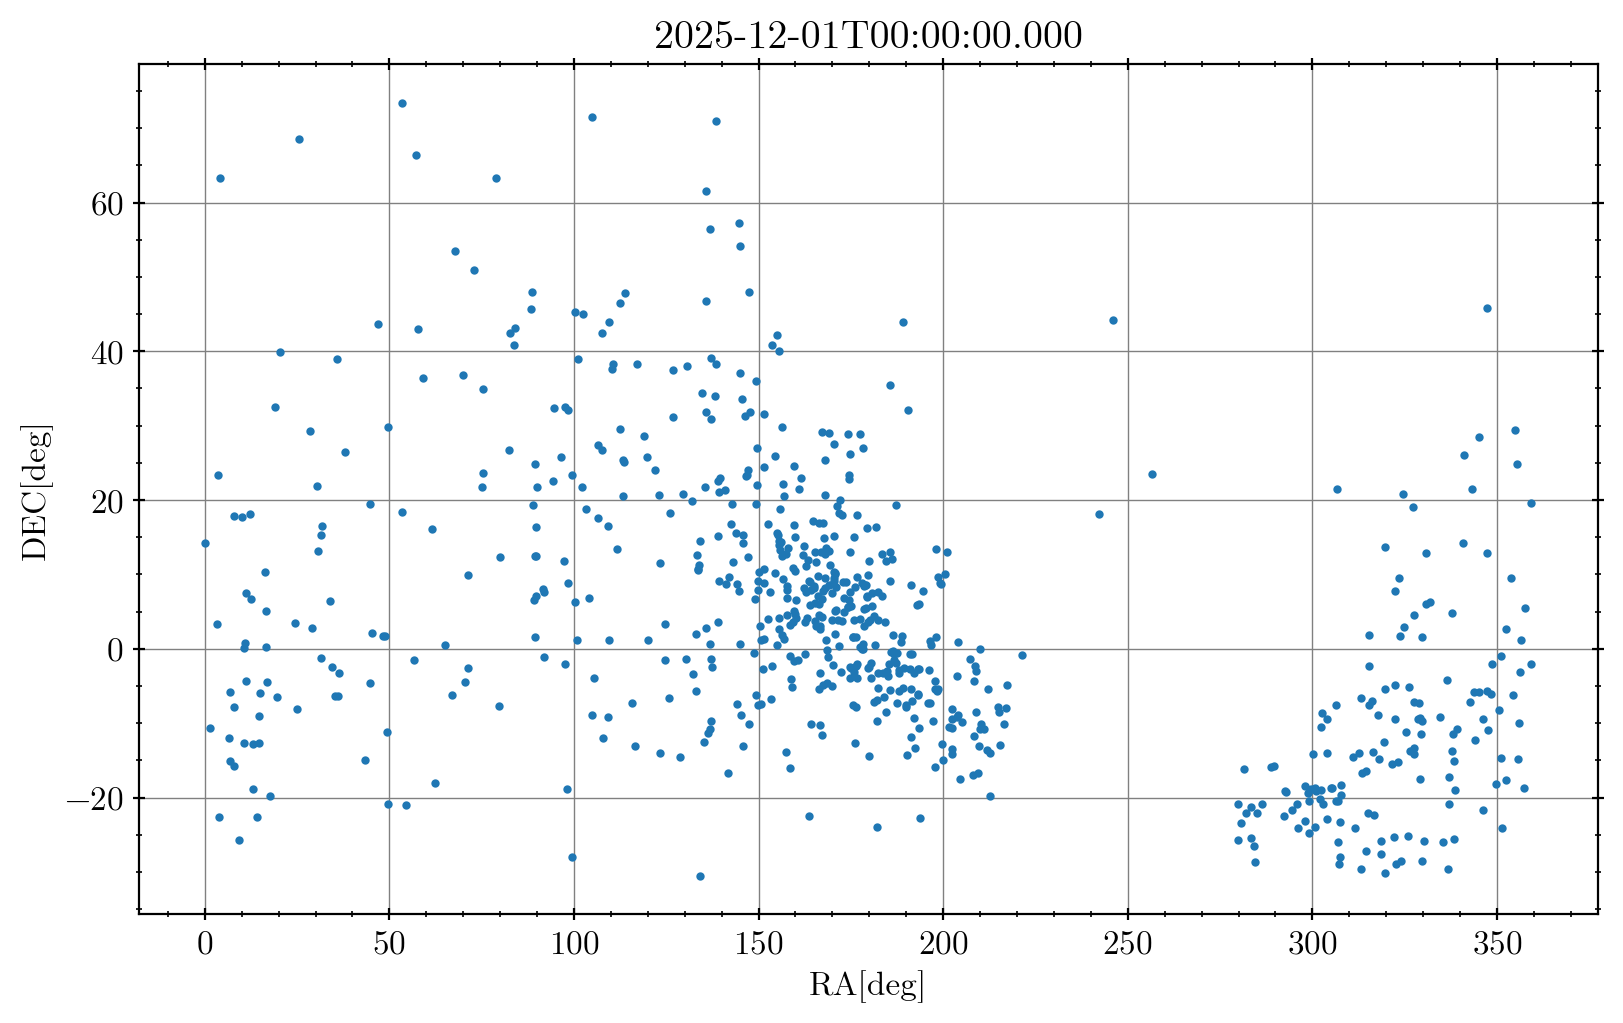

In [13]:
t0 = times[0].utc.isot
_eph = eph.loc[eph["jd_utc"] == times[0].utc.jd]
fig, axs = plt.subplots(1, 1, figsize=(8, 5), layout="constrained", gridspec_kw=None, sharex=False, sharey=False)

axs.plot(_eph["ra"], _eph["dec"], "o", markersize=2)
axs.set(
    title=t0,
    xlabel="RA[deg]",
    ylabel="DEC[deg]"
)

plt.show();